The idea is to create some new imbeddings for the "ground truth" of each object with an added semantic direction. "a photo of a {ground truth} from {direction}".

In [1]:
from clip_pipeline import CLIPModel
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil, sqrt

model = CLIPModel()
with open('Embeddings/Dataset.json', 'r') as f:
    dataset = json.load(f)
with open('Data/Dataset/GT_labels.json', 'r') as f:
    GT_labels = json.load(f)

In [30]:
# semantic direction
direction = [
   # Basic geometric directions
   "front", "back", "left", "right", #"side", "top", "bottom",
   
   # Perspective/viewpoint terms
   #"above", "below", "overhead", "underneath", "behind", "forward", "backward", "sideways", "profile",
   
   # Angular/rotational
   #"diagonal", "angled", "tilted", "rotated", "upright", "inverted", "horizontal", "vertical",
]

# compute semantic embeddings
labels, semantic_labels = list(), list()
for i,obj in enumerate(dataset["rot"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]} from the"))
    semantic_labels.append([])
    for v in range(len(direction)):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} from the {direction[v]}."))
        #semantic_labels[i].append(model.embed(f"{direction[v]}"))

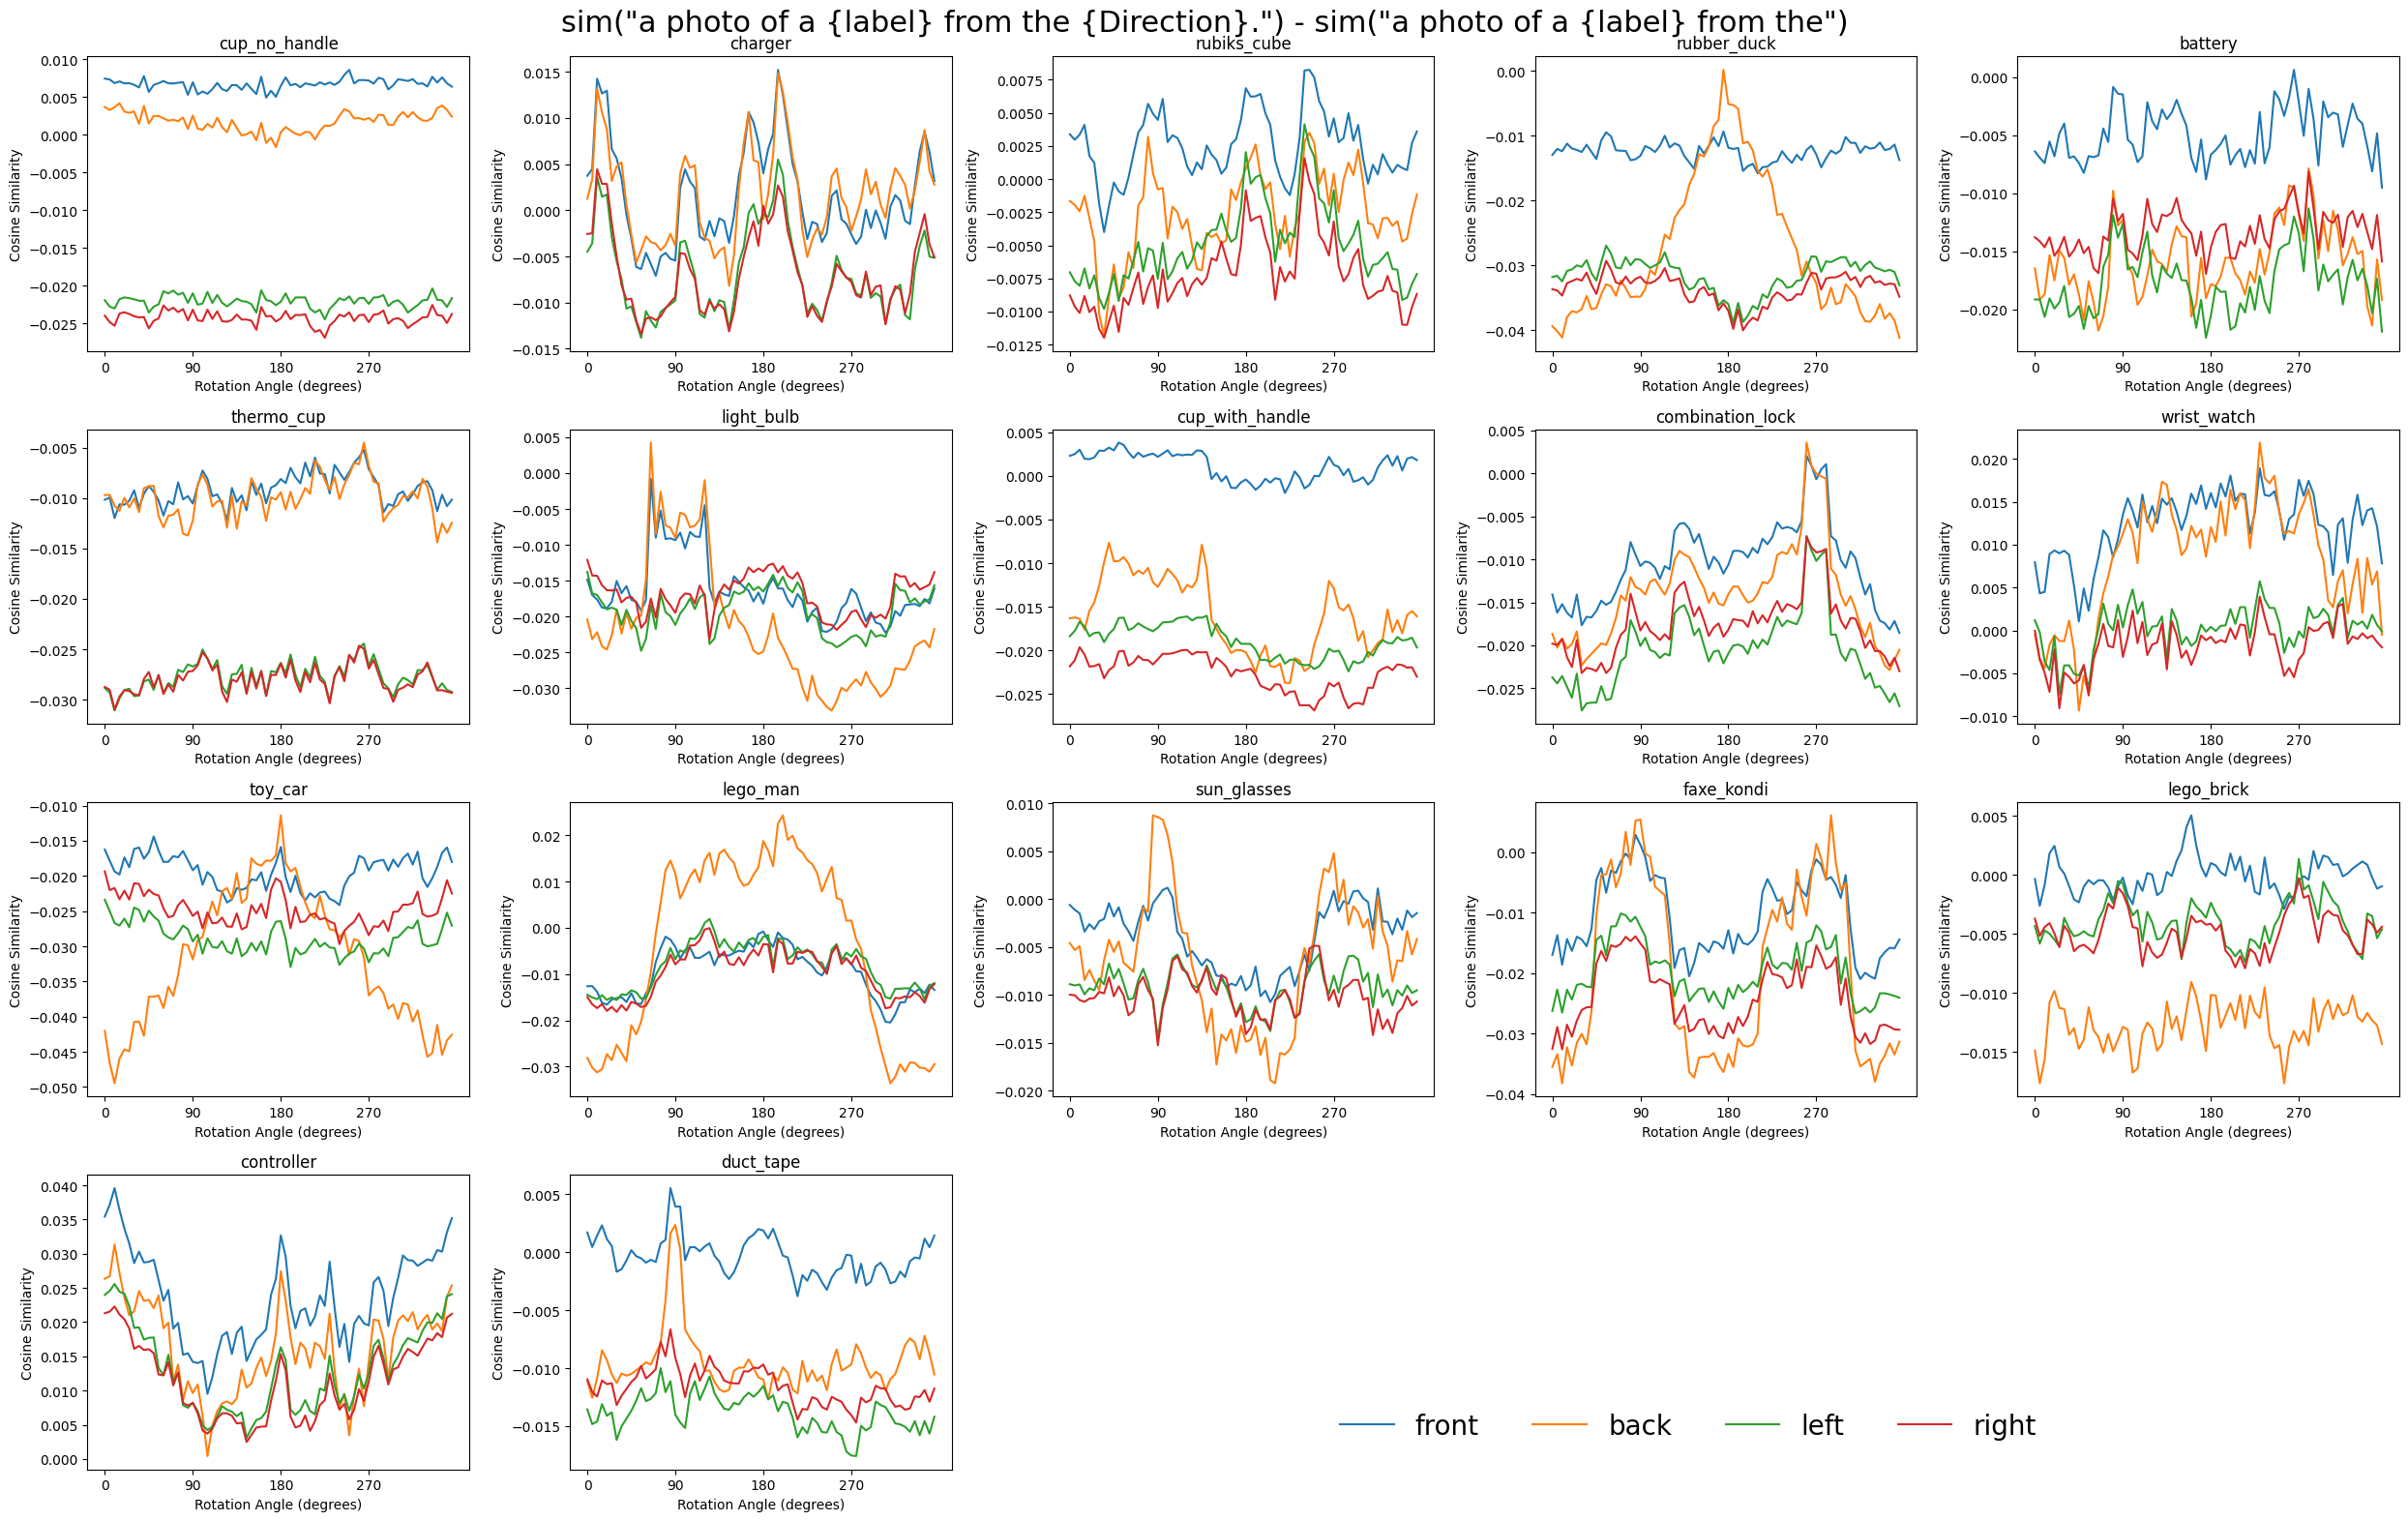

In [31]:
num_objs = len(dataset["rot"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

total_all_sims = []
for obj_idx, (obj, ax) in enumerate(zip(dataset["rot"].keys(), axes.flat)):
    all_sims = []
    for i in range(72):
        sims = []
        for v in range(len(direction)):
            sim_semantic = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]).reshape(1, -1)
            )[0, 0]
            sim = cosine_similarity(
                np.array(dataset["rot"][obj][f"{i*5}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = sim_semantic - sim
            sims.append(sim_delta)
            #mean = np.mean(sims)
            #sims = [s - mean for s in sims]
        all_sims.append(sims)
    total_all_sims.append(all_sims)
    
    for v in range(len(direction)):
        sims = [all_sims[i][v] for i in range(72)]
        ax.plot(range(72), sims, label=f'{direction[v]}')
    ax.set_xticks([i*18 for i in range(4)])
    ax.set_xticklabels([f'{i*90}' for i in range(4)])
    ax.set_xlabel('Rotation Angle (degrees)')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title(f'{obj}')

fig.suptitle('sim("a photo of a {label} from the {Direction}.") - sim("a photo of a {label} from the")', fontsize=22)

handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_,
           ncol=4,
           loc='lower center',
           bbox_to_anchor=(0.7, 0.04),
           fontsize=20,
           frameon=False)

for idx in range(num_objs, rows * cols):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.show()



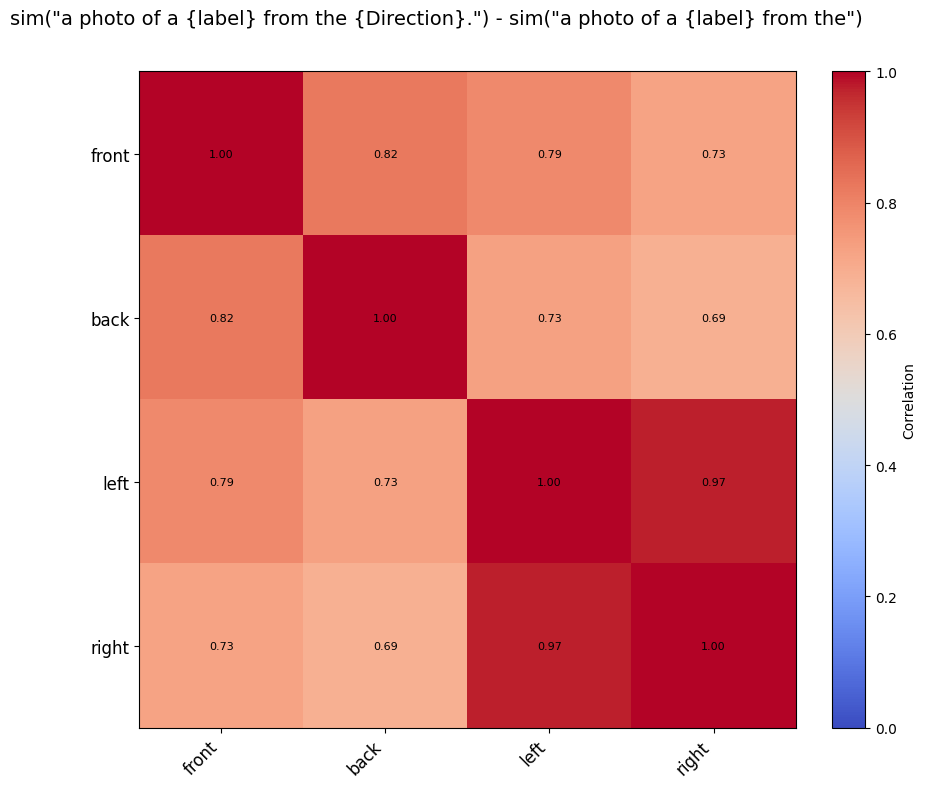

In [32]:
# Convert all_sims to a numpy array for easier manipulation
all_sims_arr = np.vstack(total_all_sims)  # shape: (num_objs*72, len(direction))

# Compute correlation matrix between the directions
corr_matrix = np.corrcoef(all_sims_arr, rowvar=False)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, vmin=0, vmax=1, cmap='coolwarm')

# Set ticks and labels
ax.set_xticks(np.arange(len(direction)))
ax.set_yticks(np.arange(len(direction)))
ax.set_xticklabels(direction, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(direction, fontsize=12)

# Annotate correlation values
for i in range(len(direction)):
    for j in range(len(direction)):
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=8)

fig.suptitle('sim("a photo of a {label} from the {Direction}.") - sim("a photo of a {label} from the")', fontsize=14)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


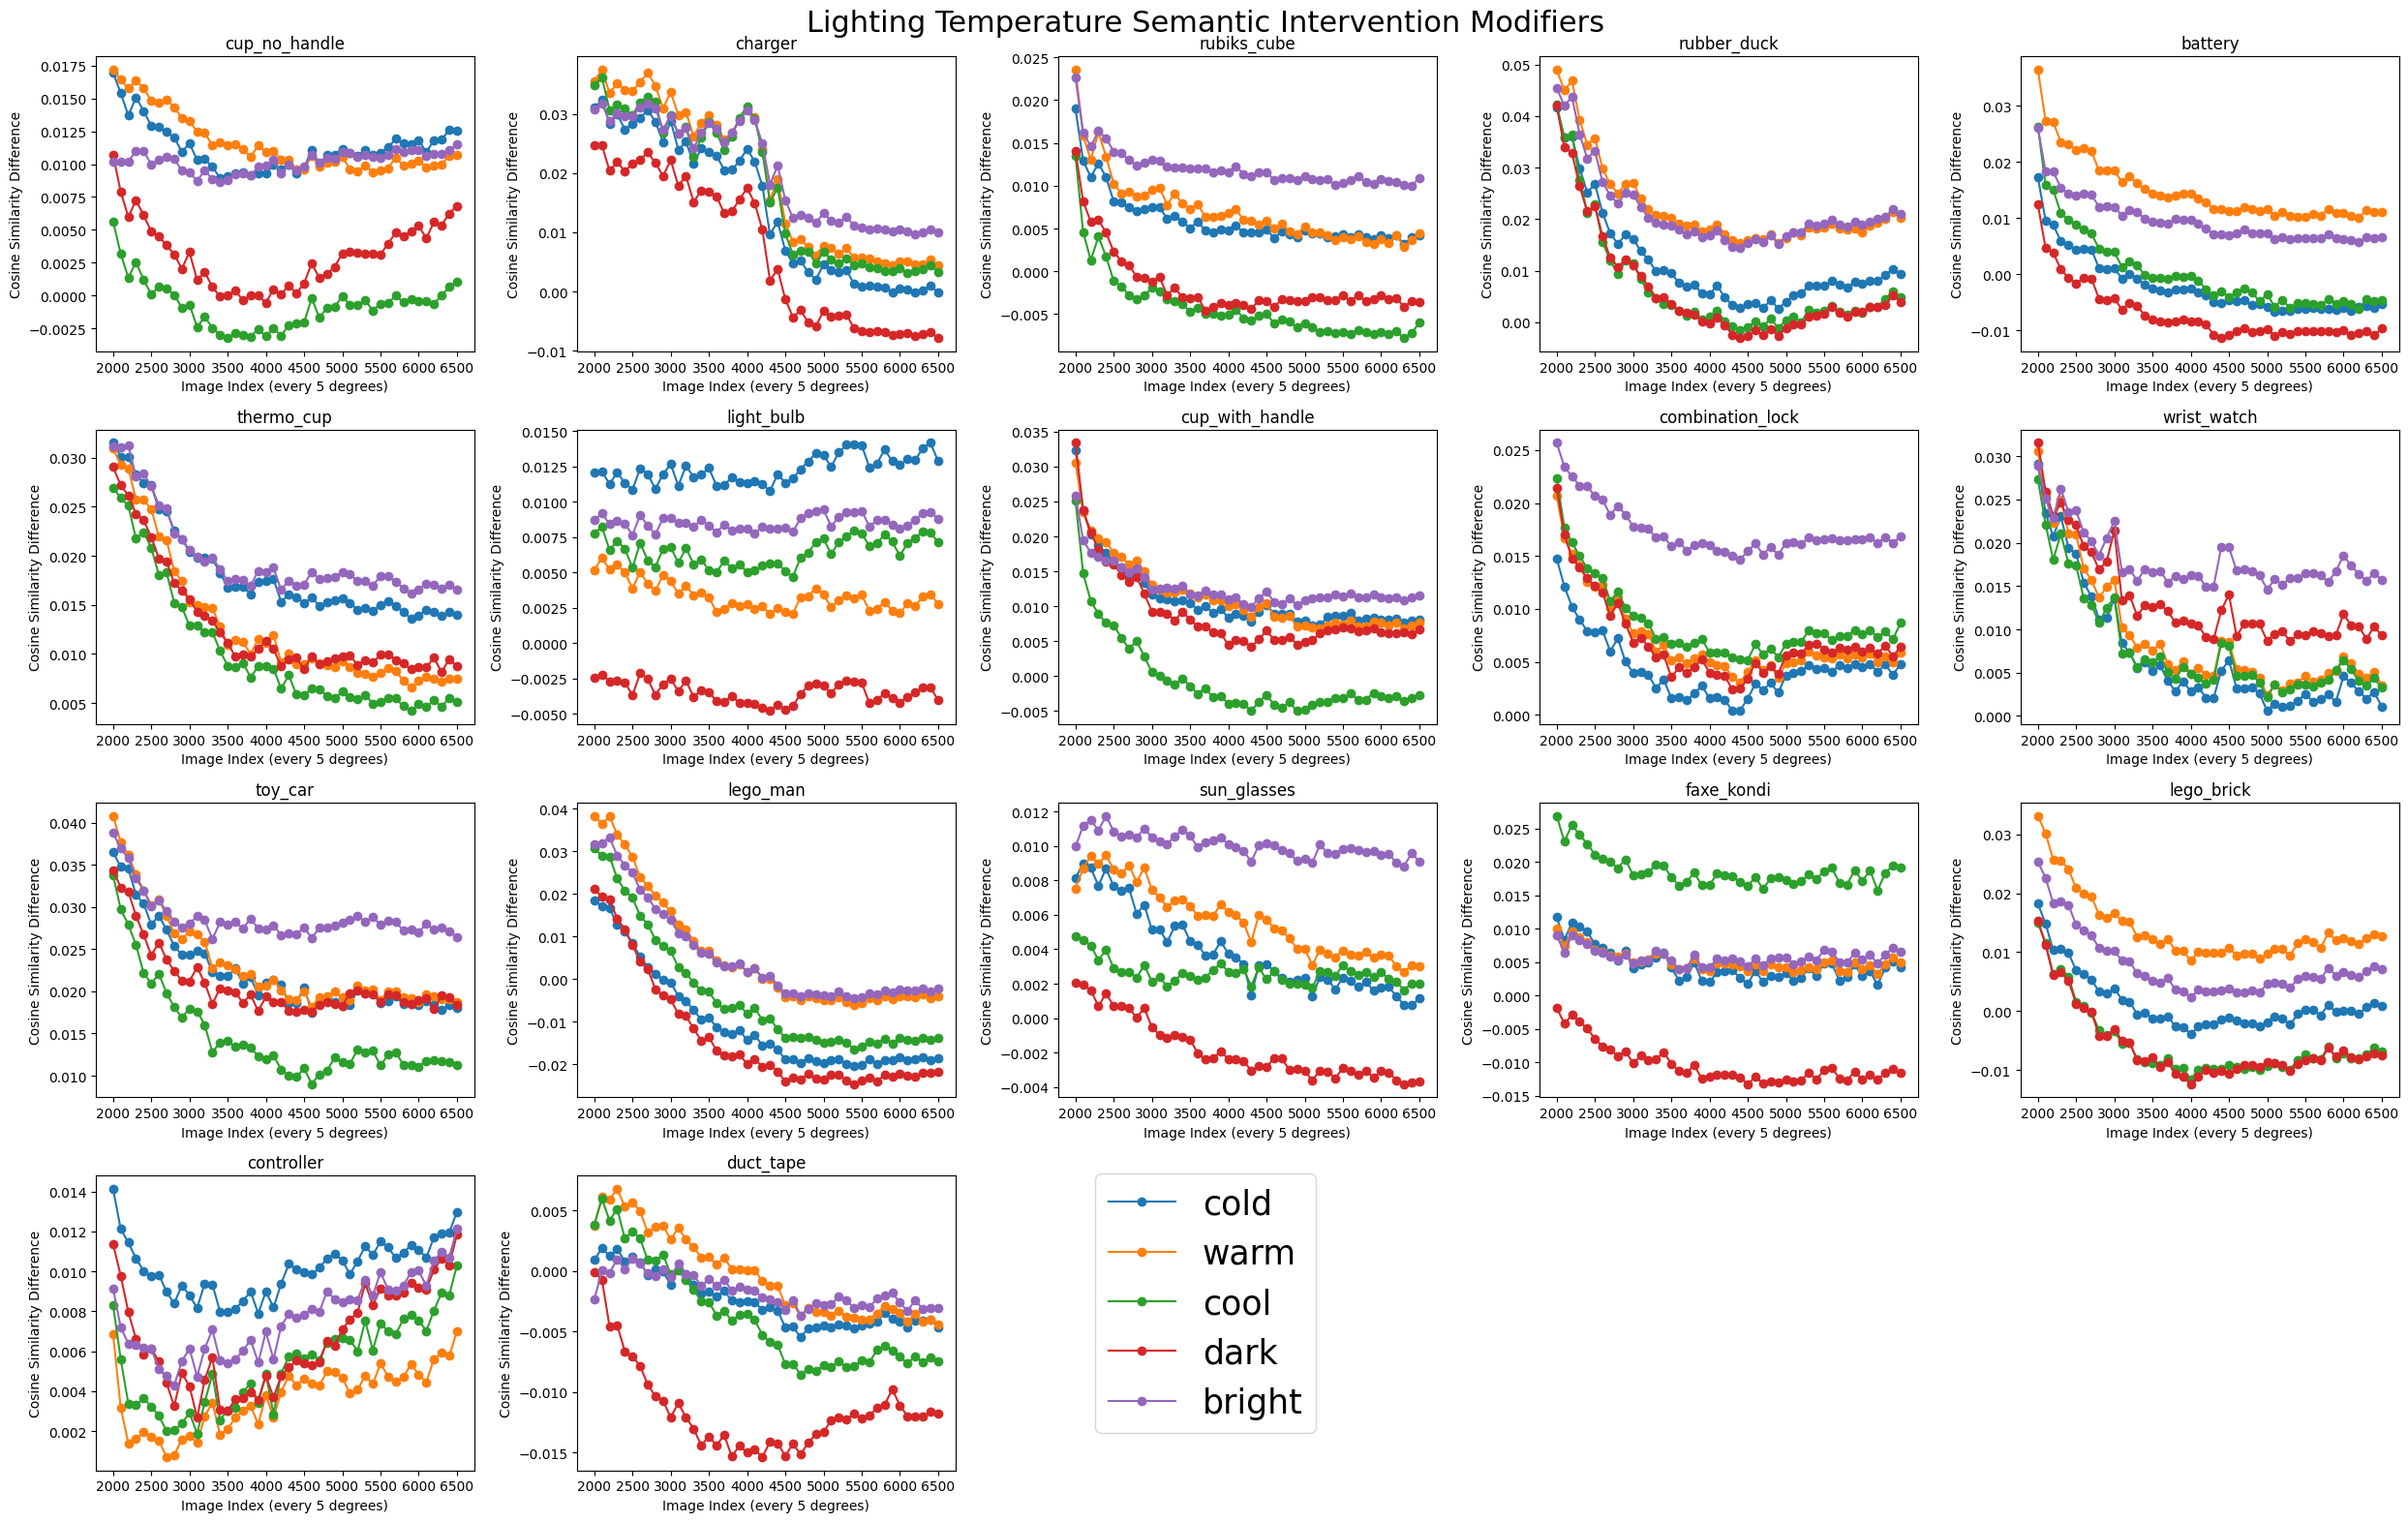

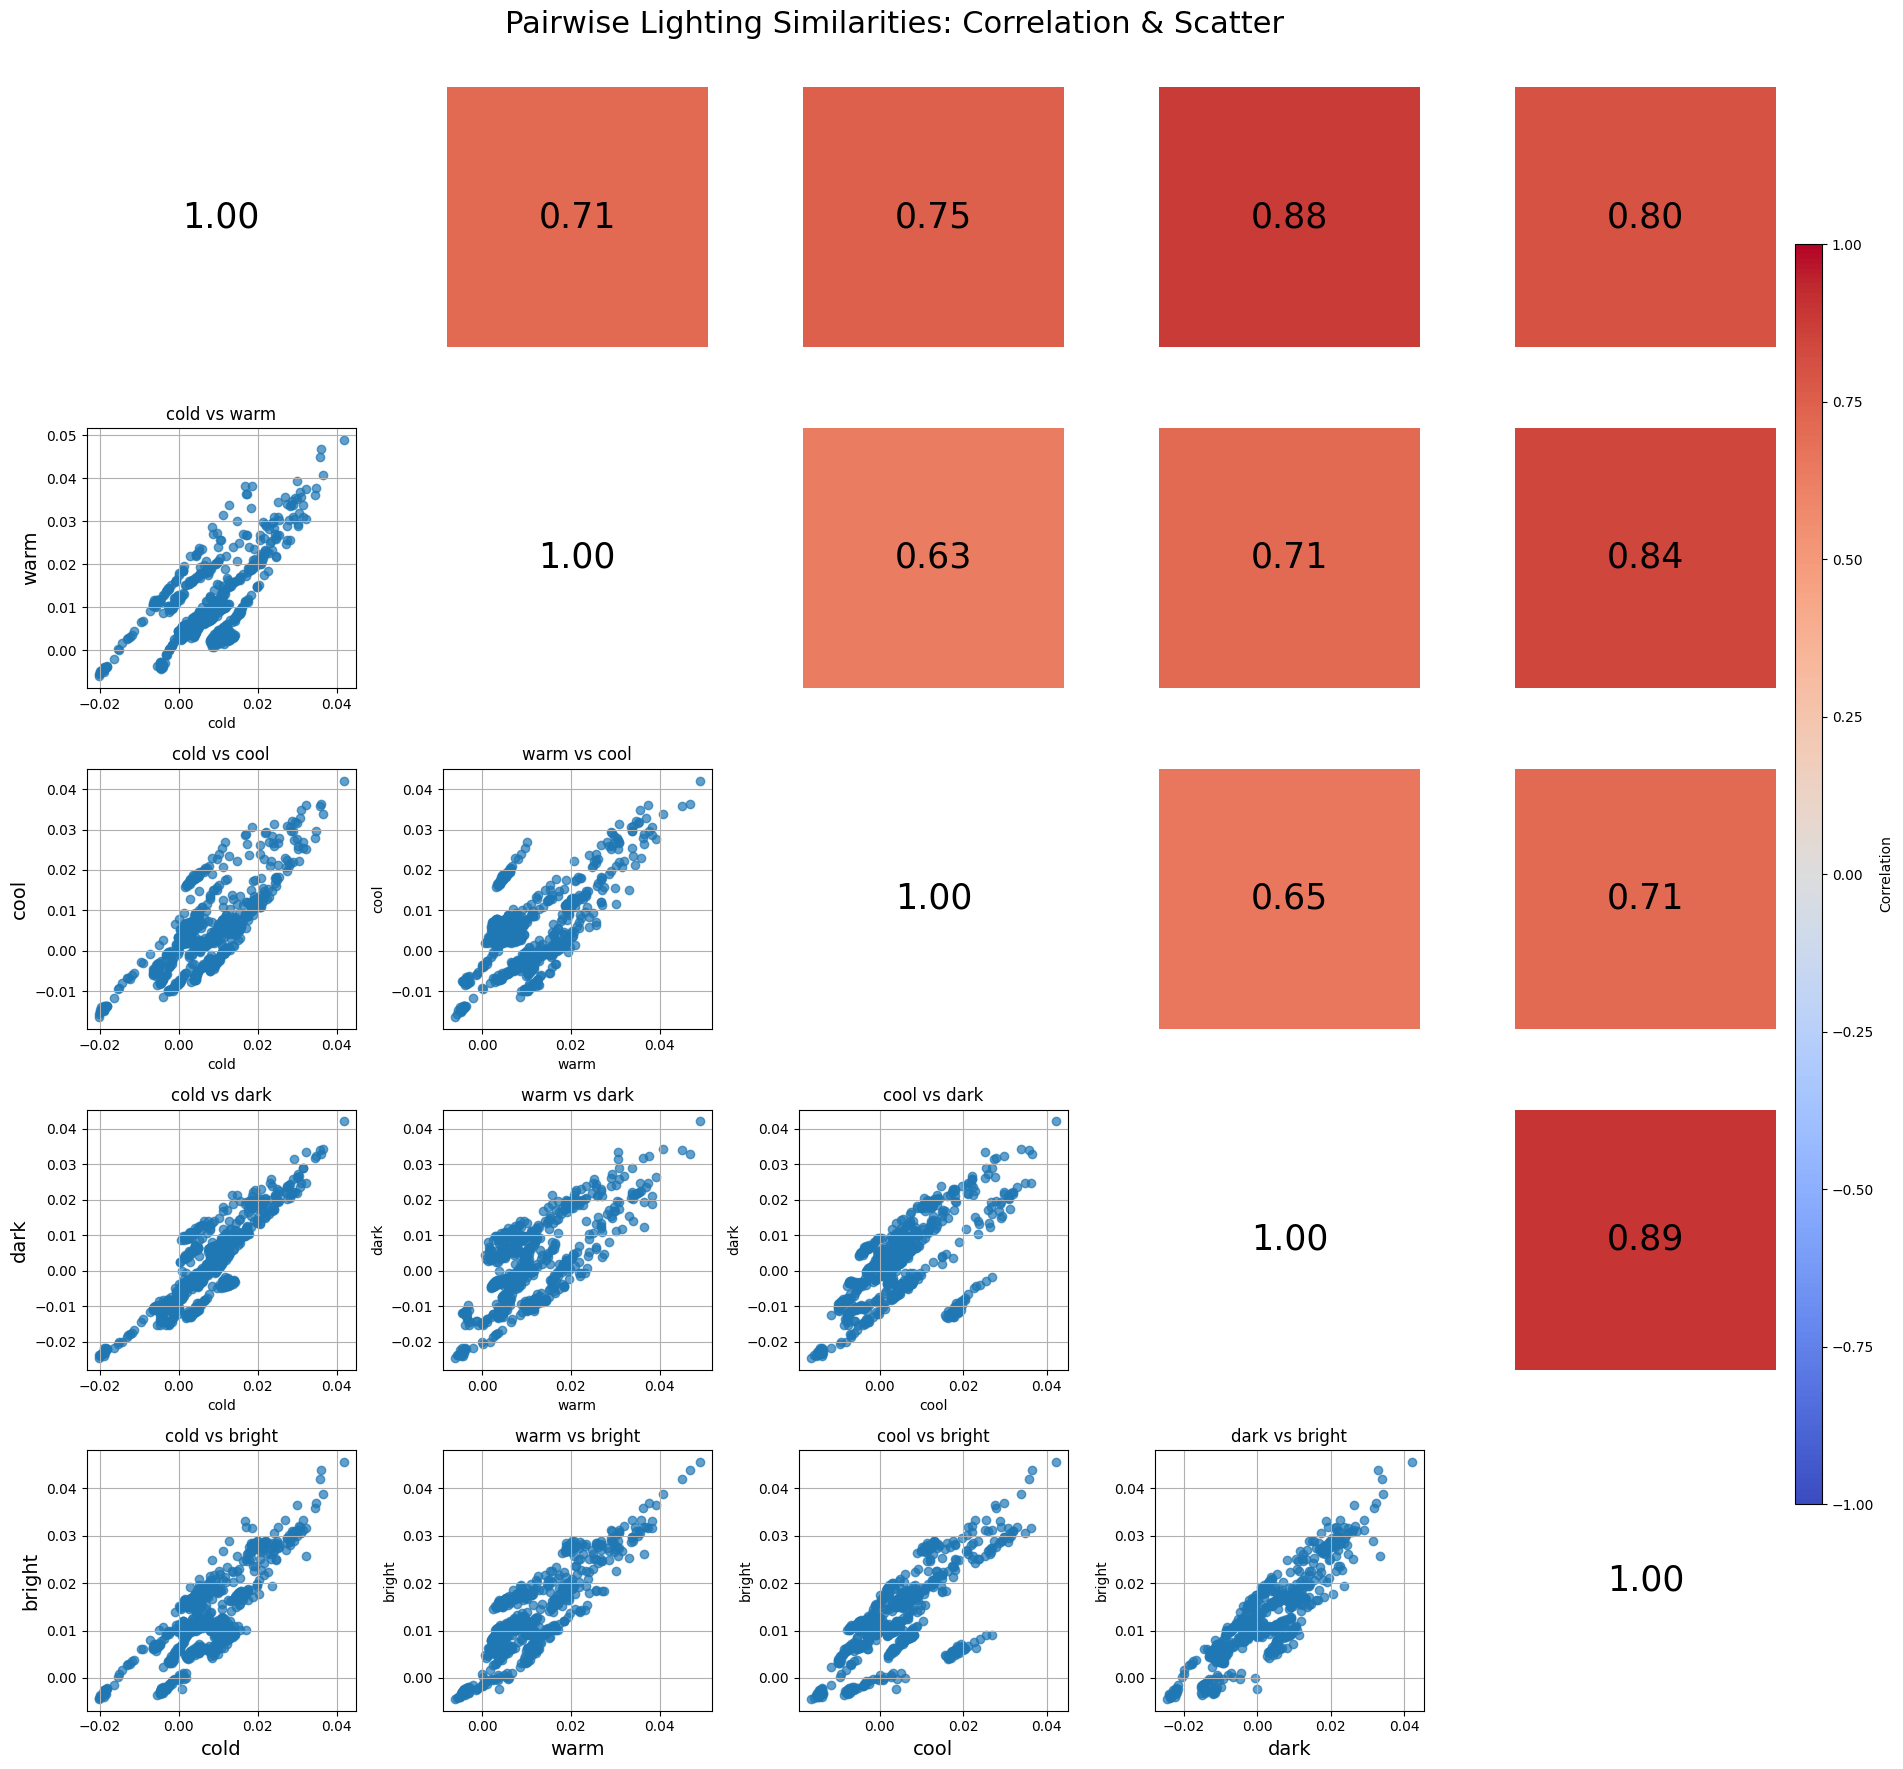

In [166]:
# semantic direction
direction = ["cold", "warm", "cool", "dark", "bright"]

# compute semantic embeddings
labels, semantic_labels = list(), list()
for i,obj in enumerate(dataset["temp"].keys()):
    labels.append(model.embed(f"a photo of a {GT_labels[obj]}."))
    semantic_labels.append([])
    for v in range(5):
        semantic_labels[i].append(model.embed(f"a photo of a {GT_labels[obj]} in {direction[v]} lighting."))


num_objs = len(dataset["temp"].keys())
cols = int(ceil(sqrt(num_objs)))
rows = int(ceil(num_objs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

total_all_sims = []
for obj_idx, (obj, ax) in enumerate(zip(dataset["temp"].keys(), axes.flat)):
    all_sims = []
    for i in range(46):
        sims = []
        for v in range(5):
            sim_semantic = cosine_similarity(
                np.array(dataset["temp"][obj][f"{2000 + i*100}"]).reshape(1, -1),
                np.array(semantic_labels[obj_idx][v]).reshape(1, -1)
            )[0, 0]
            sim = cosine_similarity(
                np.array(dataset["temp"][obj][f"{2000 + i*100}"]).reshape(1, -1),
                np.array(labels[obj_idx]).reshape(1, -1)
            )[0, 0]
            sim_delta = sim_semantic - sim
            sims.append(sim_delta)
            #mean = np.mean(sims)
            #sims = [s - mean for s in sims]
        all_sims.append(sims)
    total_all_sims.append(all_sims)
    
    for v in range(5):
        sims = [all_sims[i][v] for i in range(46)]
        ax.plot(range(46), sims, marker='o', label=f'{direction[v]}')
    ax.set_xticks([i*5 for i in range(10)])
    ax.set_xticklabels([f'{2000 + i*500}' for i in range(10)])
    ax.set_xlabel('Image Index (every 5 degrees)')
    ax.set_ylabel('Cosine Similarity Difference')
    ax.set_title(f'{obj}')

handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='lower center', bbox_to_anchor=(0.5, 0.05), fontsize=25)
fig.suptitle('Lighting Temperature Semantic Intervention Modifiers', fontsize=22)

for idx in range(num_objs, rows * cols):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.show()


# Convert all_sims to a numpy array for easier manipulation
# total_all_sims is a list of 17 arrays, each of shape (72, 4)
# Stack along axis=0 to get shape (17, 72, 4), then reshape to (17*72, 4)
all_sims_arr = np.vstack(total_all_sims)  # shape: (17*72, 4)

# Compute correlation matrix between the 5 directions
corr_matrix = np.corrcoef(all_sims_arr, rowvar=False)

fig, axes = plt.subplots(5, 5, figsize=(18, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i > j:
            # Lower triangle: scatter plot
            ax.scatter(all_sims_arr[:, j], all_sims_arr[:, i], alpha=0.7)
            ax.set_xlabel(direction[j])
            ax.set_ylabel(direction[i])
            ax.set_title(f'{direction[j]} vs {direction[i]}')
            ax.grid(True)
        elif i == j:
            # Diagonal: show correlation value (always 1)
            ax.text(0.5, 0.5, f"1.00", ha='center', va='center', fontsize=25)
            ax.set_axis_off()
        else:
            # Upper triangle: show correlation heatmap cell
            im = ax.imshow([[corr_matrix[i, j]]], vmin=-1, vmax=1, cmap='coolwarm')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0, 0, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', fontsize=25, color='black')
            ax.set_axis_off()

# Set row and column labels
for i, label in enumerate(direction):
    axes[i, 0].set_ylabel(label, fontsize=14)
    axes[-1, i].set_xlabel(label, fontsize=14)

fig.suptitle('Pairwise Lighting Similarities: Correlation & Scatter', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.97])
# Add a colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Correlation')
cbar_ax.set_position([1, 0.15, 0.015, 0.7])
plt.show()